    Визуальный анализ ряда
    Стабилизация дисперсии 
    Выбор порядка дифференцирования
    Выбор начальных приближений для p,q,P,Q
    Анализ остатков построенной модели
    Прогнозирование с помощью финальной модели.

In [3]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from itertools import product
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import statsmodels
print statsmodels.__version__

0.8.0


1) Загрузка CSV.

In [5]:
Salary = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [6]:
Salary.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


  2) Построение ряда и визуальный анализ

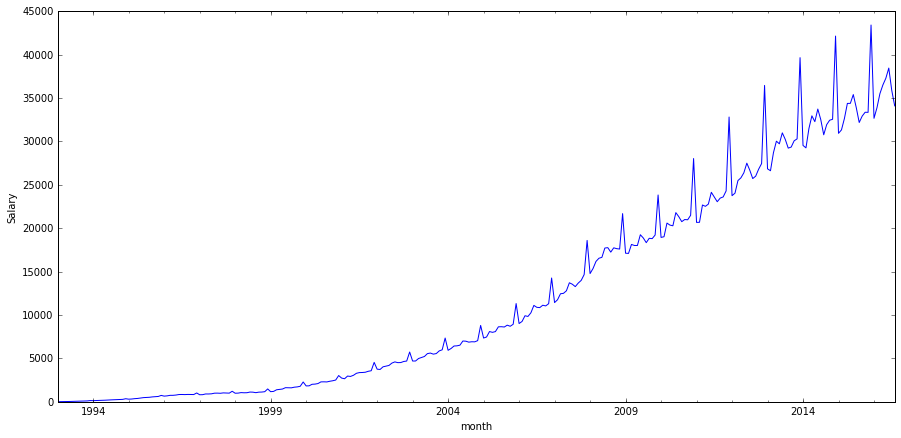

In [8]:
plt.figure(figsize(15,7))
Salary.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


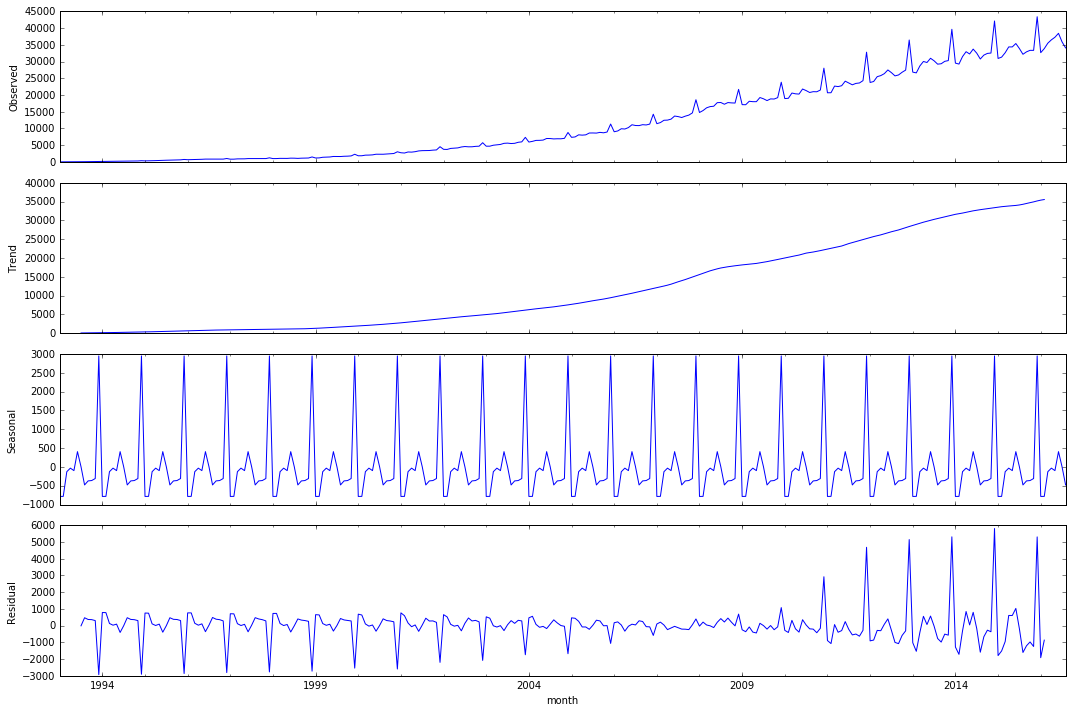

In [9]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(Salary.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(Salary.WAG_C_M)[1])

__Ряд имеет сезонность и явно выраженный тренд, дисперсия возрастает__

3) Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


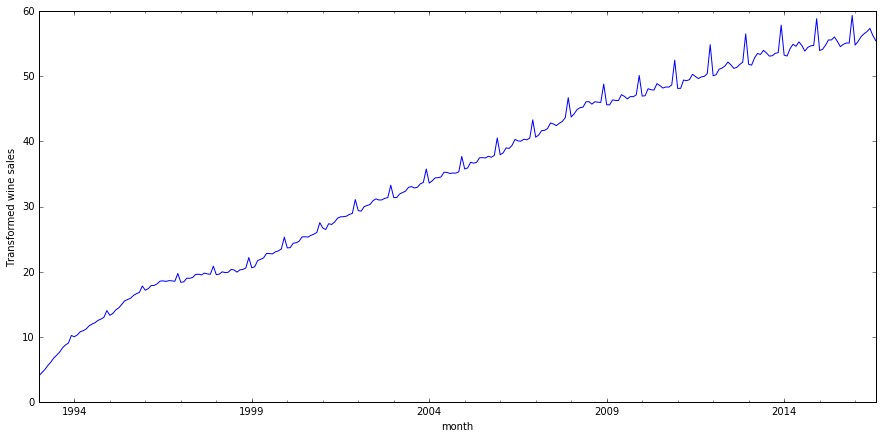

In [10]:
Salary['WAG_C_M_box'], lmbda = stats.boxcox(Salary.WAG_C_M)
plt.figure(figsize(15,7))
Salary.WAG_C_M_box.plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(Salary.WAG_C_M_box)[1])

__Дисперсия выровнялась, но не до конца__

# Стационарность¶

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:


Критерий Дики-Фуллера: p=0.014697


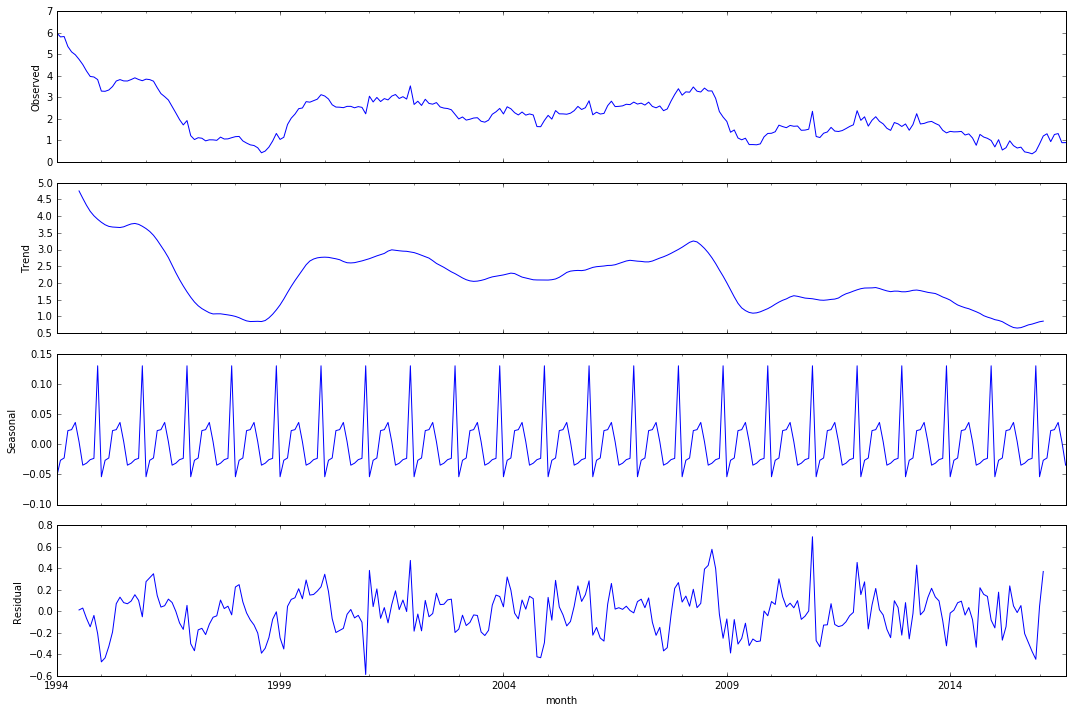

In [11]:
Salary['WAG_C_M_box_diff'] = Salary.WAG_C_M_box - Salary.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(Salary.WAG_C_M_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(Salary.WAG_C_M_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


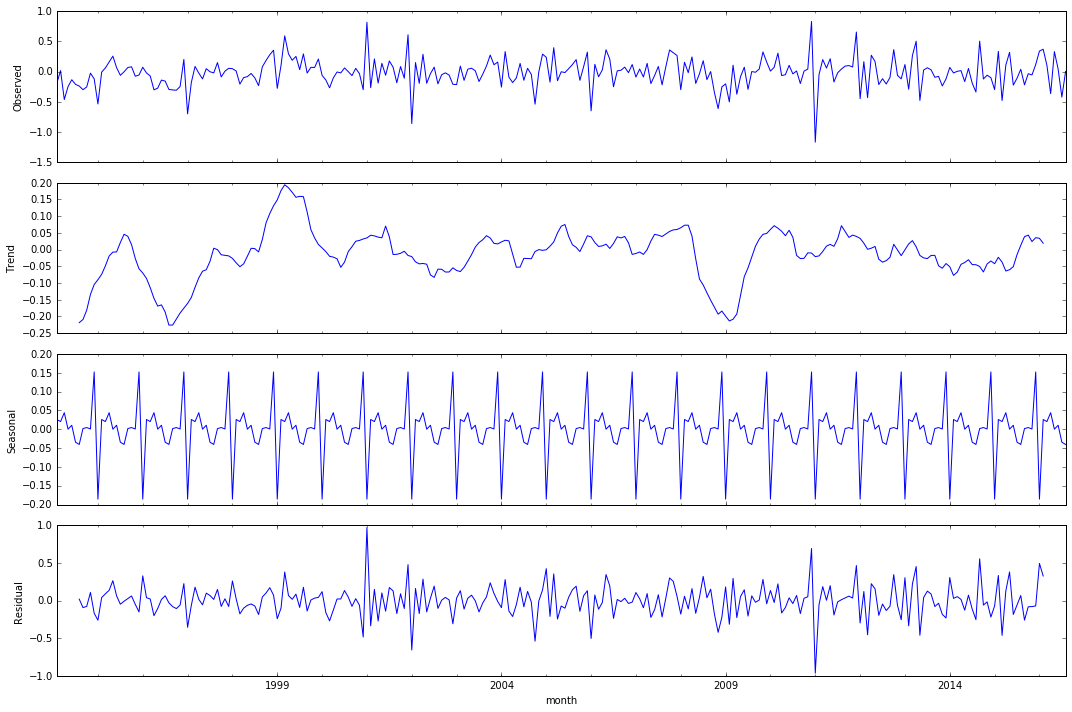

In [13]:
Salary['WAG_C_M_box_diff2'] = Salary.WAG_C_M_box_diff - Salary.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(Salary.WAG_C_M_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(Salary.WAG_C_M_box_diff2[13:])[1])

Wondeful :)

# Подбор модели

In [14]:
Salary.head()

,WAG_C_M,WAG_C_M_box,WAG_C_M_box_diff,WAG_C_M_box_diff2
month,,,,
1993-01-01,15.3,3.990393,NaN,NaN
1993-02-01,19.1,4.458758,NaN,NaN
1993-03-01,23.6,4.931635,NaN,NaN
1993-04-01,30.6,5.549430,NaN,NaN
1993-05-01,37.5,6.063406,NaN,NaN


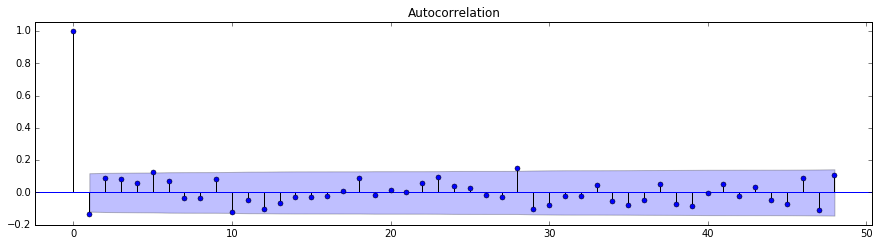

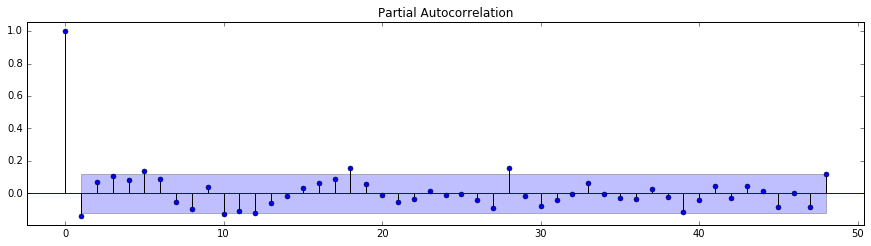

In [15]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(Salary.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(Salary.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

In [16]:
# сезонных лагов нет, но если задать Q=0,
# то в лучшей модели отчетливо будут видны
# значимые отклонения на 12 и 24 месяцах.
Q=1
q=5 
P=1
p=5 

In [17]:
ps = range(0, p+1)
d=1
qs = range(0, q+1)
Ps = range(0, P+1)
D=1
Qs = range(0, Q+1)

In [25]:
from itertools import product

In [26]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

144

In [27]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(Salary.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (1, 2, 0, 0))
('wrong parameters:', (1, 2, 0, 1))
('wrong parameters:', (1, 2, 1, 0))
('wrong parameters:', (1, 2, 1, 1))
('wrong parameters:', (2, 1, 0, 0))
('wrong parameters:', (2, 1, 0, 1))
('wrong parameters:', (2, 1, 1, 0))
('wrong parameters:', (2, 1, 1, 1))
('wrong parameters:', (2, 2, 0, 0))
('wrong parameters:', (2, 2, 0, 1))
('wrong parameters:', (2, 2, 1, 0))
('wrong parameters:', (2, 2, 1, 1))
('wrong parameters:', (3, 2, 0, 0))
('wrong parameters:', (3, 2, 0, 1))
('wrong parameters:', (3, 2, 1, 0))
('wrong parameters:', (3, 2, 1, 1))
('wrong parameters:', (4, 2, 0, 0))
('wrong parameters:', (4, 2, 0, 1))
('wrong parameters:', (4, 2, 1, 0))
('wrong parameters:', (4, 2, 1, 1))
('wrong parameters:', (4, 4, 0, 0))
('wrong parameters:', (4, 4, 0, 1))
('wrong parameters:', (4, 4, 1, 0))
('wrong parameters:', (4, 4, 1, 1))
('wrong parameters:', (5, 2, 0, 0))
('wrong parameters:', (5, 2, 0, 1))
('wrong parameters:', (5, 2,

In [28]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
105  (5, 5, 1, 0) -25.969287
104  (5, 5, 0, 1) -25.396613
106  (5, 5, 1, 1) -24.519019
103  (5, 5, 0, 0) -23.213606
41   (1, 5, 1, 0) -15.867144


In [29]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.985
Date:                            Tue, 29 Aug 2017   AIC                            -25.969
Time:                                    08:58:01   BIC                             17.818
Sample:                                01-01-1993   HQIC                            -8.414
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0356      6.552      0.005      0.996     -12.807      12.878
ar.L2          0.0125      4.489   

Критерий Стьюдента: p=0.182512
Критерий Дики-Фуллера: p=0.000000


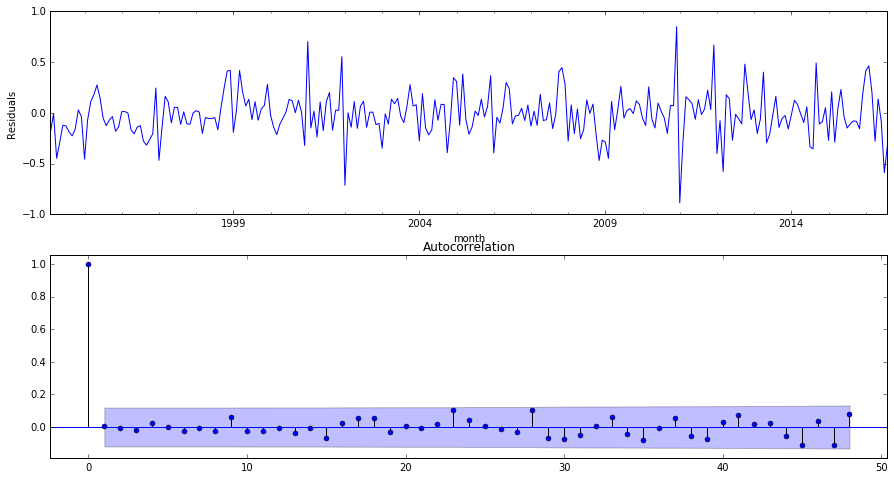

In [30]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

In [31]:
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

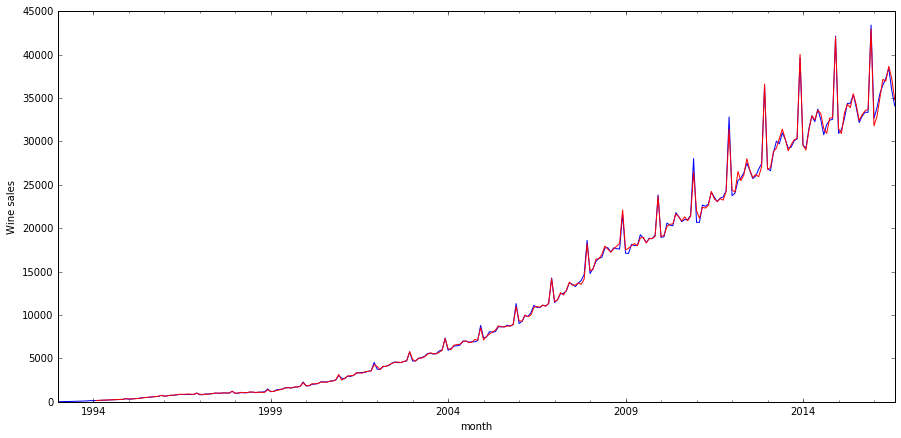

In [32]:
Salary['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
Salary.WAG_C_M.plot()
Salary.model[13:].plot(color='r')
plt.ylabel('Wine sales')
pylab.show()

# Предсказание

/usr/local/lib/python2.7/dist-packages/dateutil/rrule.py:450: DeprecationWarning: Using both 'count' and 'until' is inconsistent with RFC 2445 and has been deprecated in dateutil. Future versions will raise an error.
  "raise an error.", DeprecationWarning)


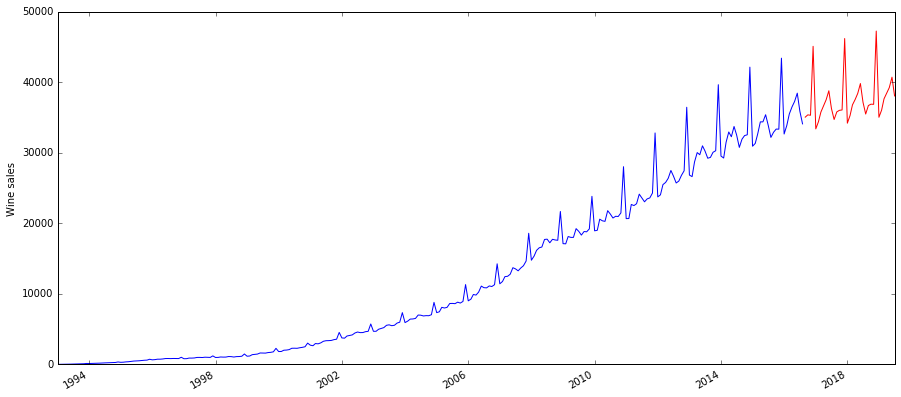

In [33]:
Salary2 = Salary[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= Salary2.columns)
Salary2 = pd.concat([Salary2, future])
Salary2['forecast'] = invboxcox(best_model.predict(start=284, end=320), lmbda)

plt.figure(figsize(15,7))
Salary2.WAG_C_M.plot()
Salary2.forecast.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()